In [6]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
import pandas as pd, numpy as np, seaborn as sns
import matplotlib.pyplot as plt
import wandb
from IPython.display import Markdown, display
from IPython.core.debugger import set_trace

In [84]:
seed = 420
np.random.seed(seed)

run_name = "mild-jazz-178"
wandb_run_path = "uts_nlp/travis_attack/36206pkc"  # get this from wandb overview section 

# Init W&B run object
api = wandb.Api()
run = api.run(wandb_run_path)
config = run.config

# Load CSV files
path_results = f"../model_checkpoints/travis_attack/{run_name}/"
train            = pd.read_csv(path_results + "train.csv")
valid            = pd.read_csv(path_results + "valid.csv")
test             = pd.read_csv(path_results + "test.csv")
training_step    = pd.read_csv(path_results + "training_step.csv")
training_summary = pd.read_csv(path_results + "training_summary.csv")

In [85]:
def display_all(df):
    with pd.option_context("display.max_rows", 1000): 
        with pd.option_context("display.max_columns", 1000): 
            with pd.option_context("max_colwidth", 480):
                display(df) 

## General run information 

In [86]:
## Some markdown below 
Markdown(f"""
### Summary 

**Dataset**: {config['dataset_name']}  
**Paraphrase model**: `{config['pp_name']}`  
**Victim model**: `{config['vm_name']}`  
**Semantic Textual Similarity model**: `{config['sts_name']}`  
**Number of epochs**: {config['n_train_epochs']}  
**Reward function**: `{config['reward_strategy']}`  
**Using the full dataset**: {True if not config['use_small_ds'] else f"False: n_shards set to {config['shard_params']['n_shards']} shards with shard_contiguous set to {config['shard_params']['shard_contiguous']}"}   
We freeze all layers of the paraphrase model except the last **{config['n_layers_frozen']}** layers.  
We eval every **{config['eval_freq']}** epochs.   

### Paraphrase parameters 
**Decoding strategy**: {config['sampling_strategy']}  
**Number of beams**: {config['pp_model_params']['num_beams']}  
**Number of return sequences**: {config['pp_model_params']['num_return_sequences']}  
**Max length**: {config['pp_model_params']['max_length']}  
**Min length**: {config['pp_model_params']['min_length']}  
**Temperature**: {config['pp_model_params']['temperature']}  
**Length penalty**: {config['pp_model_params']['length_penalty']}  
**Number of beam groups**: {config['pp_model_params']['num_beam_groups']}  
**Diversity penalty**: {config['pp_model_params']['diversity_penalty']}  

  
### Run parameters
**Seed**: {config['seed']}  
**Learning rate**: {config['lr']}  
**Batch sizes:** Train: {config['batch_size_train']}, Eval: {config['batch_size_eval']}  
**Max number of tokens in input**: {config['max_length']}  
**Remove initially misclassified examples**: {config['remove_misclassified_examples']}  
**Input bucketed by length:** {config['bucket_by_length']}  
**Shuffle training data:** {config['shuffle_train']}  
**Pad input data to multiple of**: {config['padding_multiple']}  
**Pad embedding matrices**: {config['pad_token_embeddings']}  
**Normalise rewards?**: {config['normalise_rewards']}  
**Gradient accumulation?**: {False if config['accumulation_steps'] == 1  else f"Every {config['accumulation_steps']} steps"}  

### Low-level parameters 
**Use fp16 for training?**: {config['fp16']}  
**Use memory pinning with dataloaders?**: {config['pin_memory']}  
**Initilise gradients with `None` when running `zero_grad()`**: {config['zero_grad_with_none']}  
""")


### Summary 

**Dataset**: rotten_tomatoes  
**Paraphrase model**: `eugenesiow/bart-paraphrase`  
**Victim model**: `textattack/distilbert-base-uncased-rotten-tomatoes`  
**Semantic Textual Similarity model**: `sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2`  
**Number of epochs**: 30  
**Reward function**: `[-0.5 if sts < 0.5 else 0.5+v*sts for v,sts in zip(vm_scores, sts_scores)]`  
**Using the full dataset**: True   
We freeze all layers of the paraphrase model except the last **2** layers.  
We eval every **1** epochs.   

### Paraphrase parameters 
**Decoding strategy**: greedy  
**Number of beams**: 1  
**Number of return sequences**: 1  
**Max length**: 64  
**Min length**: 5  
**Temperature**: 1.5  
**Length penalty**: 1  
**Number of beam groups**: 1  
**Diversity penalty**: 0  

  
### Run parameters
**Seed**: 420  
**Learning rate**: 3e-05  
**Batch sizes:** Train: 32, Eval: 128  
**Max number of tokens in input**: 64  
**Remove initially misclassified examples**: True  
**Input bucketed by length:** True  
**Shuffle training data:** False  
**Pad input data to multiple of**: 8  
**Pad embedding matrices**: True  
**Normalise rewards?**: False  
**Gradient accumulation?**: False  

### Low-level parameters 
**Use fp16 for training?**: True  
**Use memory pinning with dataloaders?**: True  
**Initilise gradients with `None` when running `zero_grad()`**: False  


## Training summary 

In [87]:
## Some markdown below
Markdown(f"""For this one go to the [dashboard](https://wandb.ai/{wandb_run_path}) and have a look at it manually""")

For this one go to the [dashboard](https://wandb.ai/uts_nlp/travis_attack/36206pkc) and have a look at it manually

## Dataset-level stats

In [183]:
df = training_step  # can set to train, valid or test (and maybe training_step)
df = df.sort_values(by=['idx', "epoch"], axis=0)
# Getting weird behaviour with group_by's so binning some of the numeric values
df['sts_score'] = df['sts_score'].round(4) 
df['vm_score'] = df['vm_score'].round(4) 
df['reward'] = df['reward'].round(4) 
df['pp_truelabel_probs'] = df['pp_truelabel_probs'].round(4) 

#display_all(df)

Fraction of examples with more than one paraphrase tried: 0.677


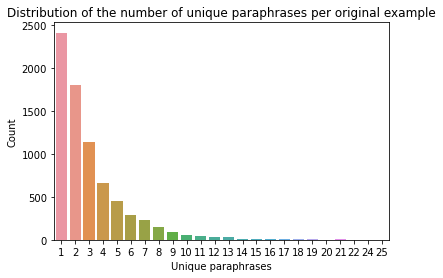

In [185]:
def add_number_of_unique_pps_per_idx(df): 
    df_grp = df.groupby("idx").agg({"pp_l":"nunique"})
    df_grp= df_grp.rename(columns = {"pp_l":"idx_n_unique_pp"})
    # plot histogram
    fig = sns.countplot(x='idx_n_unique_pp', data=df_grp) 
    plt.title("Distribution of the number of unique paraphrases per original example")
    plt.xlabel("Unique paraphrases")
    plt.ylabel("Count") 
    # Add column to orig df and return 
    df = df.merge(df_grp, left_on='idx', right_index=True, how='left')
    return df

df = add_number_of_unique_pps_per_idx(df)
# some summary statistics 
counts = df[['idx','idx_n_unique_pp']].drop_duplicates()['idx_n_unique_pp'].value_counts()
print(f"Fraction of examples with more than one paraphrase tried: {1 - (counts.iloc[0]/sum(counts)).round(3)}")

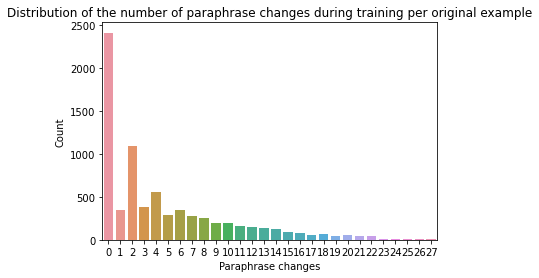

In [186]:
def add_number_of_pp_changes_per_idx(df): 
    df['pp_changed'] = df.sort_values(["idx","epoch"]).groupby('idx')['pp_l'].shift().ne(df['pp_l']).astype(int)
    df_grp = df.groupby('idx').agg({'pp_changed': 'sum'})
    df_grp= df_grp.rename(columns = {"pp_changed":"idx_n_pp_changes"})
    df_grp['idx_n_pp_changes'] -= 1  # The first paraphrase isn't a change
    df = df.drop('pp_changed', 1) # don't need this anymore 
    
    # Plot histogram
    fig = sns.countplot(x='idx_n_pp_changes', data=df_grp) 
    plt.title("Distribution of the number of paraphrase changes during training per original example")
    plt.xlabel("Paraphrase changes")
    plt.ylabel("Count")
    
    # Add column to orig df before returning 
    df = df.merge(df_grp, left_on='idx', right_index=True, how='left')
    return df 
df = add_number_of_pp_changes_per_idx(df)

Fraction of examples with a label flip at some point: 0.07599999999999996


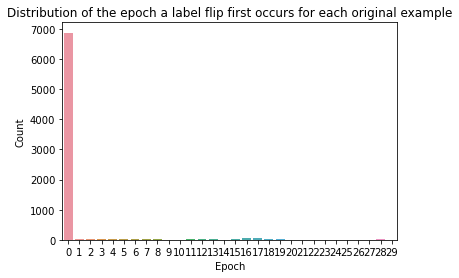

In [187]:
def add_epoch_of_first_label_flip(df): 
    rownum_of_first_flip = df.groupby('idx')[['epoch','label_flip']].idxmax()['label_flip']
    ## idxmax returns first max
    df_grp = df[['idx','epoch']].loc[rownum_of_first_flip]
    df_grp= df_grp.rename(columns = {"epoch":"epoch_of_first_label_flip"})
    fig = sns.countplot(x='epoch_of_first_label_flip', data=df_grp)
    plt.title("Distribution of the epoch a label flip first occurs for each original example")
    plt.xlabel("Epoch")
    plt.ylabel("Count")
    df = df.merge(df_grp, left_on='idx', right_on='idx', how='left')
    return df
df = add_epoch_of_first_label_flip(df)
# some summary statistics 
counts = df[['idx','epoch_of_first_label_flip']].drop_duplicates()['epoch_of_first_label_flip'].value_counts()
print(f"Fraction of examples with a label flip at some point: {1 - (counts.iloc[0]/sum(counts)).round(3)}")


In [188]:
# Sampling some low sts score examples 
#display_all(df.query('sts_score < 0.7').sort_values('sts_score').sample(10)[['orig_l','pp_l','sts_score']])

## Individual examples 

In [189]:
def get_interesting_idx(df, n):
    def get_idx_with_top_column_values(cname, n=5, ascending=False):
        return df[['idx',cname]].\
            drop_duplicates().\
            sort_values(cname, ascending=ascending)\
            ['idx'][0:n].values.tolist()
    
    def sample_idx_with_label_flips(n=5): 
        return df[['idx','epoch_of_first_label_flip']].\
            query("epoch_of_first_label_flip!=0").\
            drop_duplicates()\
            ['idx'].sample(n).values.tolist()
    
    idx_d = dict(
        random           = df.idx.drop_duplicates().sample(n).tolist(),
        label_flips = sample_idx_with_label_flips(n=n),
        idx_n_unique_pp  = get_idx_with_top_column_values('idx_n_unique_pp',n=n,ascending=False),
       # idx_n_pp_changes = get_idx_with_top_column_values('idx_n_pp_changes',n=n,ascending=False),
        low_sts = get_idx_with_top_column_values('sts_score',n=n,ascending=True)
      #  orig_long = None, 
      #  orig_short = None,
    )
    return idx_d


In [190]:
n=5
idx_d = get_interesting_idx(df, n)
#idx_d

def print_stats(key,i):
    print("\n###############\n")
    print(key, i, "\n")
    idx = idx_d[key][i]
    # Setup 
    df1 = df.query('idx==@idx')
    orig = pd.unique(df1['orig_l'])[0]
    print("Original:", orig)
    print("Original label", pd.unique(df1['truelabel'])[0] )
    pp_all = list(df1['pp_l'])
    #print("All paraphrases", pp_all)
    pp_unique = list(pd.unique(df1['pp_l']))
    n_pp_unique = len(pp_unique)

    # showing a "timeline" of how the paraphrases change over the epochs
    g_fields = ["pp_l","pp_truelabel_probs","vm_score","sts_score","reward","label_flip"]
    #g_fields = ["pp_l","vm_score"]
    g = df1.groupby(g_fields).agg({'epoch' : lambda x: list(x)})
    g = g.sort_values(by='epoch', key = lambda col: col.map(lambda x: np.min(x)))
    print("Unique paraphrases:", n_pp_unique)
    print("How the paraphrases change:")
    display_all(g)

    # Showing a dataframe of the few best paraphrases
    best_pps = df1.sort_values('pp_truelabel_probs').iloc[0]
    print("Best Paraphrase")
    display_all(best_pps.to_frame().T)

    #print("Everything")
    #display_all(df1)
  
for key in idx_d.keys():
    for i in range(n): 
        print_stats(key,i)